In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from theano import shared
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
az.style.use('arviz-darkgrid')

path = "iris.csv"

# Load the data
data = pd.read_csv(path)

# Extract the data
sepal_length_data = data['sepal_length'].values
petal_length_data = data['petal_length'].values
petal_width_data = data['petal_width'].values

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


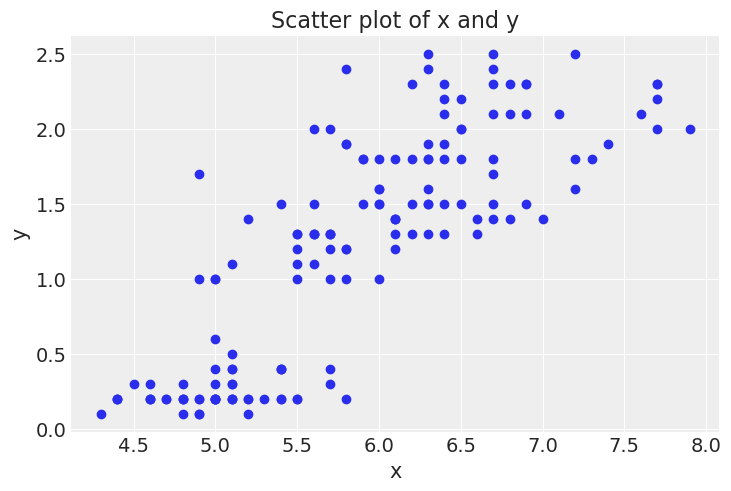

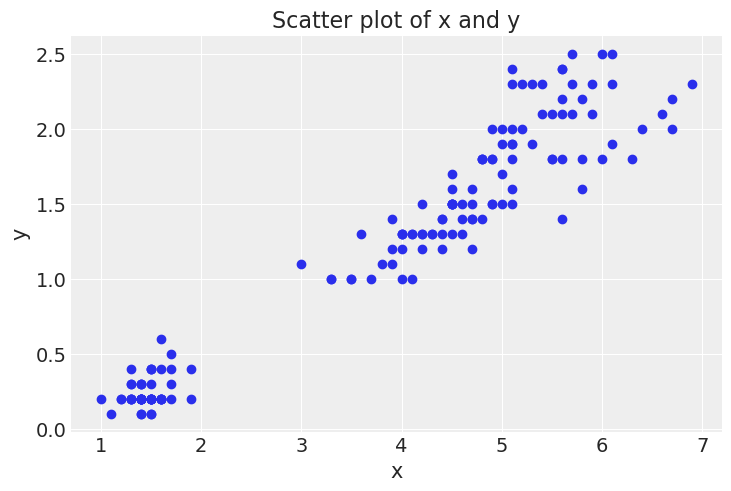

In [2]:
def scatter_plot(x, y):
    plt.scatter(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scatter plot of x and y')
    plt.show()

scatter_plot(sepal_length_data, petal_width_data)
scatter_plot(petal_length_data, petal_width_data)
#plt.savefig('B11197_03_20.png', dpi=300)

In [11]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * sepal_length_data + β2 * petal_length_data

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=petal_width_data)

    idata_x1x2 = pm.sample(2000, return_inferencedata=True)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * sepal_length_data

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=petal_width_data)

    idata_x1 = pm.sample(2000, return_inferencedata=True)
    intercept_x1 = idata_x1.posterior["α"].mean().item()
    slope1_x1 = idata_x1.posterior["β1"].mean().item()
    print('slope: ')
    print(slope1_x1)
    print ('intercept: ')
    print (intercept_x1)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * petal_length_data

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=petal_width_data)

    idata_x2 = pm.sample(2000, return_inferencedata=True)
    intercept_x2 = idata_x2.posterior["α"].mean().item()
    slope1_x2 = idata_x2.posterior["β2"].mean().item()
    print('slope: ')
    print(slope1_x2)
    print ('intercept: ')
    print(intercept_x2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 56 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.
The acceptance probability does not match the target. It is 0.880036148648564, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8791975451641701, but should be close to 0.8. Try to increase the number of tuning steps.


slope: 
0.7527921370697238
intercept: 
-3.1992695470545867


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.


slope: 
0.415717845506975
intercept: 
-0.36305536414731565


In [20]:
# Calculate R-squared
posterior_pred = pm.sample_posterior_predictive(idata_x1x2, samples=2000, model=m_x1x2)
observed_data = petal_width_data
y_pred_mean = posterior_pred['y_pred'].mean(0)

# Calculate the R-squared value
SSR = ((observed_data - y_pred_mean) ** 2).sum()
SST = ((observed_data - observed_data.mean()) ** 2).sum()
r_squared = 1 - SSR / SST

print('R-squared:', r_squared)

ppc = pm.sample_posterior_predictive(idata_x1x2, model=m_x1x2)
az.r2_score(petal_width_data, ppc['y_pred'])

c:\Users\shaya\anaconda3\envs\pm3bap\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


R-squared: 0.9288817058200395


r2        0.925015
r2_std    0.001318
dtype: float64

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

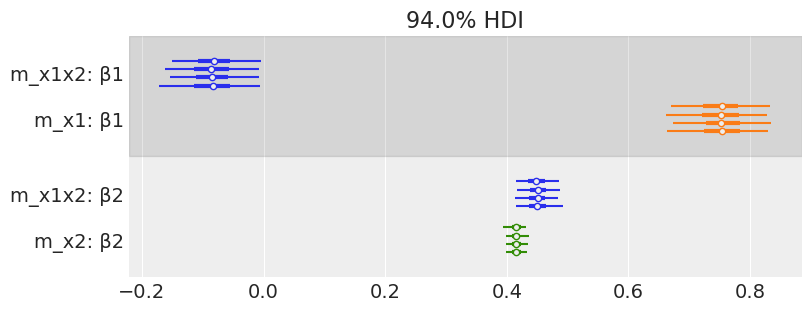

In [19]:
az.plot_forest([idata_x1x2, idata_x1, idata_x2],model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],combined=False, colors='cycle', figsize=(8, 3))

As we can see, B1 for model m_x1x2 is near to 0, which indicates an almost null contribution of sepal_length variable to explain y. With that being said, B1 for model m_x1 is around 0.8, which means that the ability for sepal_length to predict y is greatly reduced when petal_length is taken in to account.

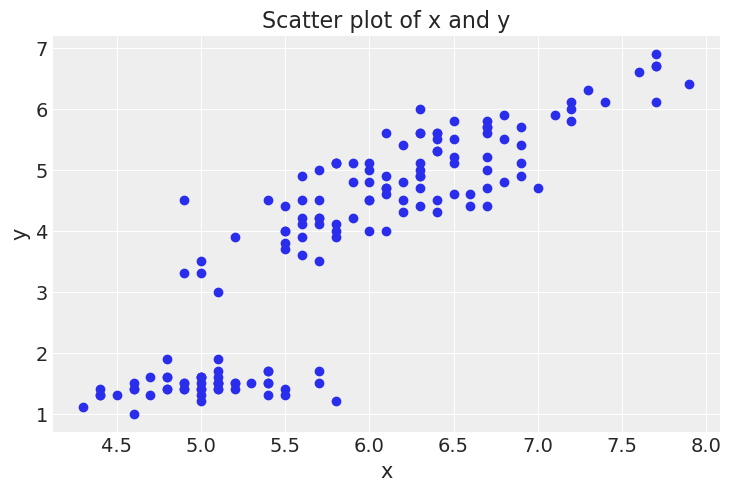

In [5]:
scatter_plot(sepal_length_data, petal_length_data)

In [6]:
with pm.Model() as m_independents:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * sepal_length_data

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=petal_length_data)

    idata_independent2 = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.71102017225131, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

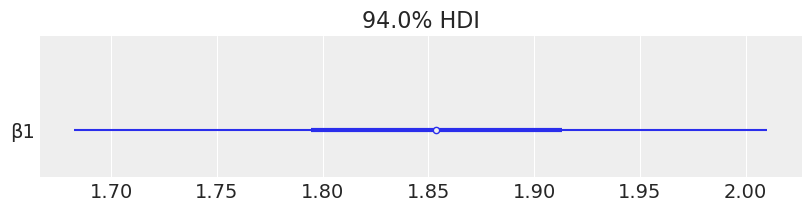

In [7]:
az.plot_forest([idata_independent2], var_names=['β1'], combined=True, figsize=(8, 2))
#plt.savefig('B11197_03_24.png', dpi=300)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-7.073,0.516,-8.045,-6.115,0.010,0.007,2901.0,3086.0,1.0
β1,1.853,0.088,1.683,2.010,0.002,0.001,2922.0,2875.0,1.0


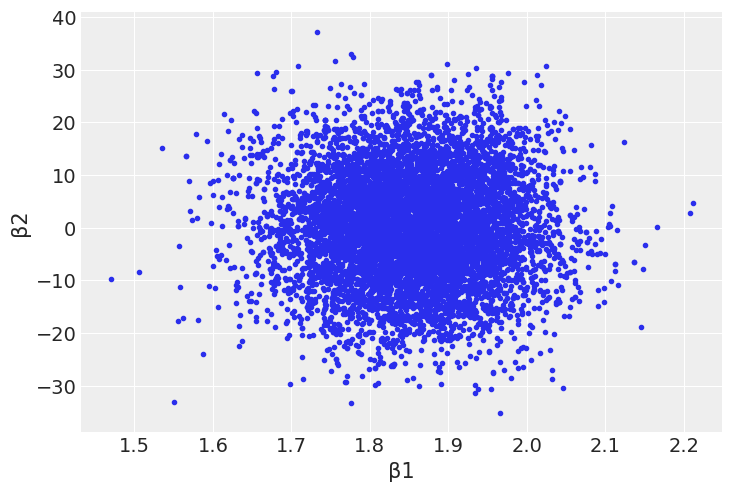

In [9]:
az.plot_pair(idata_independent2, var_names=['β1','β2'])
az.summary(idata_independent2, var_names=['α','β1'])